In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/global-student-migration-and-higher-education-trends/global_student_migration.csv


In [20]:
df = pd.read_csv('/kaggle/input/global-student-migration-and-higher-education-trends/global_student_migration.csv')
df.head()

,student_id,origin_country,destination_country,destination_city,university_name,course_name,field_of_study,year_of_enrollment,scholarship_received,enrollment_reason,graduation_year,placement_status,placement_country,placement_company,starting_salary_usd,gpa_or_score,visa_status,post_graduation_visa,language_proficiency_test,test_score
0,S00001,Finland,Russia,Moscow,Lomonosov Moscow State University,Computer Science,Engineering,2021,No,Higher Ranking,2024,Placed,Russia,Microsoft,36416,3.92,Tier 4,Work Permit,TOEFL,7.8
1,S00002,UK,Germany,Aachen,RWTH Aachen,Civil Engineering,Law,2023,Yes,Job Opportunities,2024,Placed,Germany,Google,32956,2.60,Study Permit,OPT,PTE,7.9
2,S00003,Ireland,Canada,Vancouver,University of British Columbia,Law,Arts,2019,No,Scholarship,2020,Not Placed,NaN,NaN,0,2.72,F1,Blue Card,NaN,0.0
3,S00004,UAE,UK,Birmingham,University of Birmingham,Data Science,Social Sciences,2021,Yes,Quality of Life,2023,Placed,UK,Apple,50892,3.71,Schengen Student Visa,PSW,NaN,0.0
4,S00005,South Africa,Germany,Stuttgart,University of Stuttgart,Business Administration,Law,2020,Yes,Political Stability,2021,Placed,Germany,IBM,54790,2.96,Schengen Student Visa,OPT,PTE,8.2


In [21]:
df.shape

(5000, 20)

In [22]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year_of_enrollment,5000.0,2021.01100,1.420733,2019.0,2020.0000,2021.00,2022.00,2023.0
graduation_year,5000.0,2023.01780,1.651432,2020.0,2022.0000,2023.00,2024.00,2026.0
starting_salary_usd,5000.0,44552.53100,50719.190623,0.0,0.0000,30516.50,87838.50,149932.0
gpa_or_score,5000.0,3.24682,0.430659,2.5,2.8775,3.24,3.61,4.0
test_score,5000.0,5.63220,2.973838,0.0,5.3000,6.50,7.80,9.0


In [23]:
df.info

<bound method DataFrame.info of      student_id origin_country destination_country  destination_city  \
0        S00001        Finland              Russia            Moscow   
1        S00002             UK             Germany            Aachen   
2        S00003        Ireland              Canada         Vancouver   
3        S00004            UAE                  UK        Birmingham   
4        S00005   South Africa             Germany         Stuttgart   
...         ...            ...                 ...               ...   
4995     S04996         Canada             Germany         Stuttgart   
4996     S04997          India             Ireland          Maynooth   
4997     S04998             UK               India         Bangalore   
4998     S04999        Germany              Russia  Saint Petersburg   
4999     S05000        Finland             Germany         Stuttgart   

                        university_name              course_name  \
0     Lomonosov Moscow State Univer

In [24]:
df.nunique()

student_id                   5000
origin_country                 10
destination_country            10
destination_city               51
university_name                74
course_name                    15
field_of_study                  8
year_of_enrollment              5
scholarship_received            2
enrollment_reason               5
graduation_year                 7
placement_status                2
placement_country              10
placement_company              13
starting_salary_usd          2485
gpa_or_score                  151
visa_status                     6
post_graduation_visa            5
language_proficiency_test       4
test_score                     42
dtype: int64

In [25]:
df.duplicated().sum()

0

In [26]:
df.isnull().sum()

student_id                      0
origin_country                  0
destination_country             0
destination_city                0
university_name                 0
course_name                     0
field_of_study                  0
year_of_enrollment              0
scholarship_received            0
enrollment_reason               0
graduation_year                 0
placement_status                0
placement_country            2491
placement_company            2491
starting_salary_usd             0
gpa_or_score                    0
visa_status                     0
post_graduation_visa            0
language_proficiency_test     982
test_score                      0
dtype: int64

In [27]:
# If there are missing values in numeric columns that will be used in modeling, we fill them with median values

numeric_cols = ['year_of_enrollment','graduation_year','starting_salary_usd','gpa_or_score','test_score']
for col in numeric_cols:
    if col in df.columns:
        df[col].fillna(df[col].median(), inplace=True)

# For categorical columns, fill missing values with mode

categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

#dataset after cleaning
print('\nCleaned Dataset:')
print(df.info())


Cleaned Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   student_id                 5000 non-null   object 
 1   origin_country             5000 non-null   object 
 2   destination_country        5000 non-null   object 
 3   destination_city           5000 non-null   object 
 4   university_name            5000 non-null   object 
 5   course_name                5000 non-null   object 
 6   field_of_study             5000 non-null   object 
 7   year_of_enrollment         5000 non-null   int64  
 8   scholarship_received       5000 non-null   object 
 9   enrollment_reason          5000 non-null   object 
 10  graduation_year            5000 non-null   int64  
 11  placement_status           5000 non-null   object 
 12  placement_country          5000 non-null   object 
 13  placement_company          500

/tmp/ipykernel_36/2544634538.py:6: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_36/2544634538.py:12: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df

# Visualization

<Axes: >

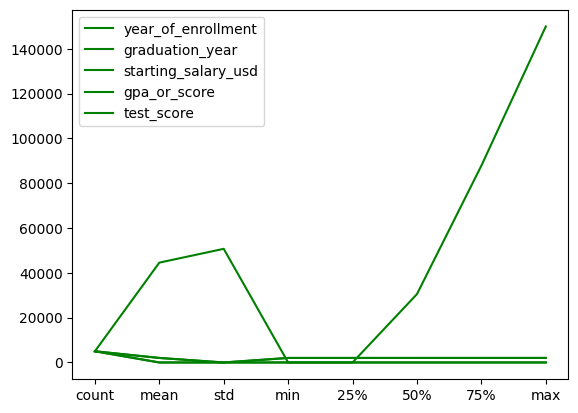

In [28]:
df.describe().plot(kind='line',color='g')

In [29]:
import plotly.express as px

In [30]:
#student migration map "origin country --> destination country"

migration = df.groupby(['origin_country', 'destination_country']).size().reset_index(name='count')
fig1 = px.sunburst(migration, path=['origin_country', 'destination_country'], values='count',
                   title='Global Student Migration Flow')
fig1.show()


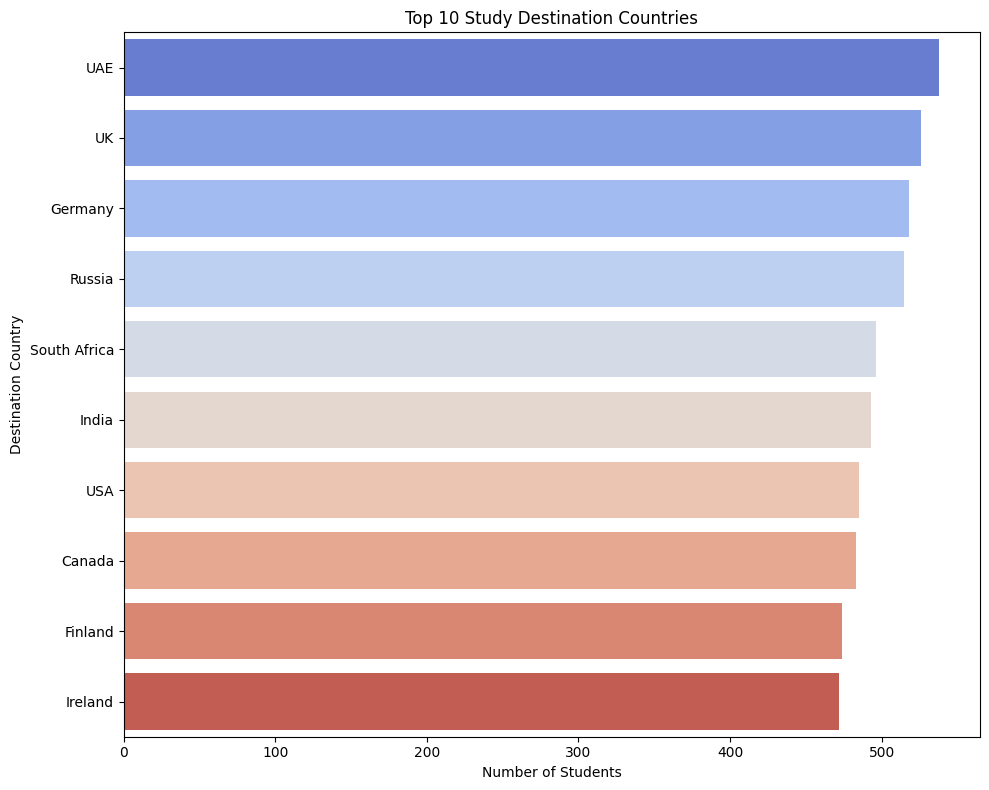

In [31]:
#top 10 destination countries

top_destination_countries = df['destination_country'].value_counts().head(10)
plt.figure(figsize=(10,8))
sns.barplot(data=df,x= top_destination_countries.values, y=top_destination_countries.index,palette='coolwarm')
plt.title('Top 10 Study Destination Countries')
plt.xlabel('Number of Students')
plt.ylabel('Destination Country')
plt.tight_layout()
plt.show()

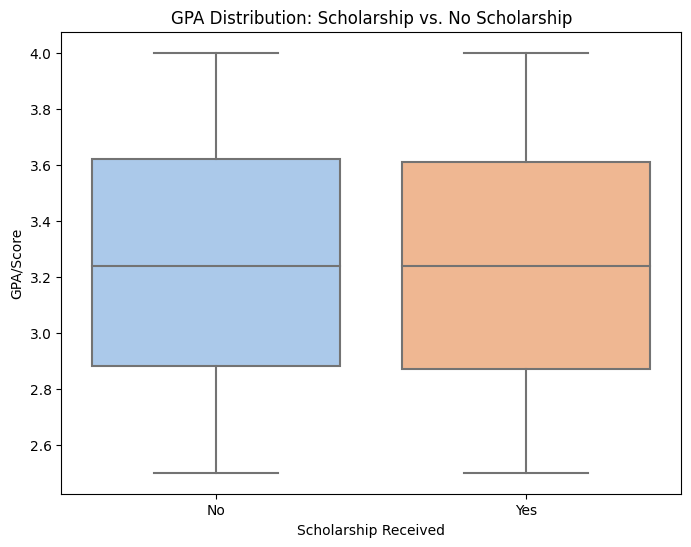

In [32]:
#scholarship vs GPA

plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='scholarship_received', y='gpa_or_score', palette='pastel')
plt.title('GPA Distribution: Scholarship vs. No Scholarship')
plt.xlabel('Scholarship Received')
plt.ylabel('GPA/Score')
plt.show()

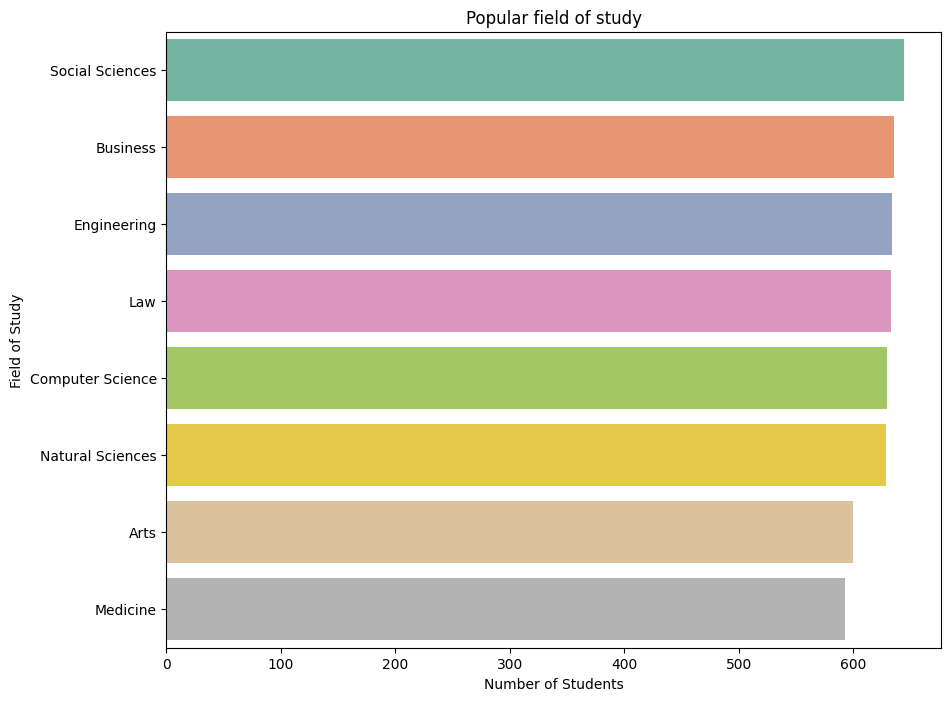

In [33]:
#field of study distribution

plt.figure(figsize=(10,8))
sns.countplot(data=df, y ='field_of_study', order = df['field_of_study'].value_counts().index, palette='Set2')
plt.title('Popular field of study')
plt.xlabel('Number of Students')
plt.ylabel('Field of Study')
plt.show()

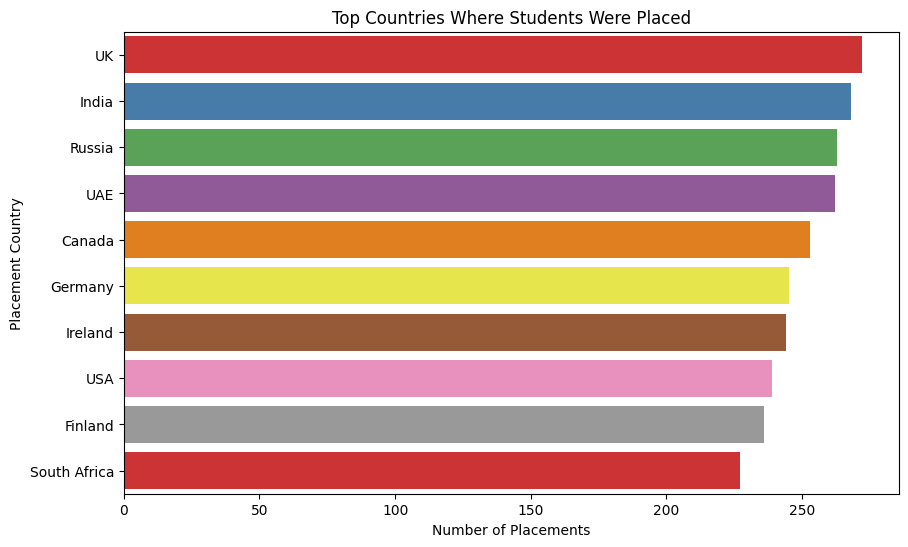

In [41]:
#Placement Status by Country

placement = df[df['placement_status'] == 'Placed']
placement_count = placement['placement_country'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=placement_count.values, y=placement_count.index, palette='Set1')
plt.title('Top Countries Where Students Were Placed')
plt.xlabel('Number of Placements')
plt.ylabel('Placement Country')
plt.show()

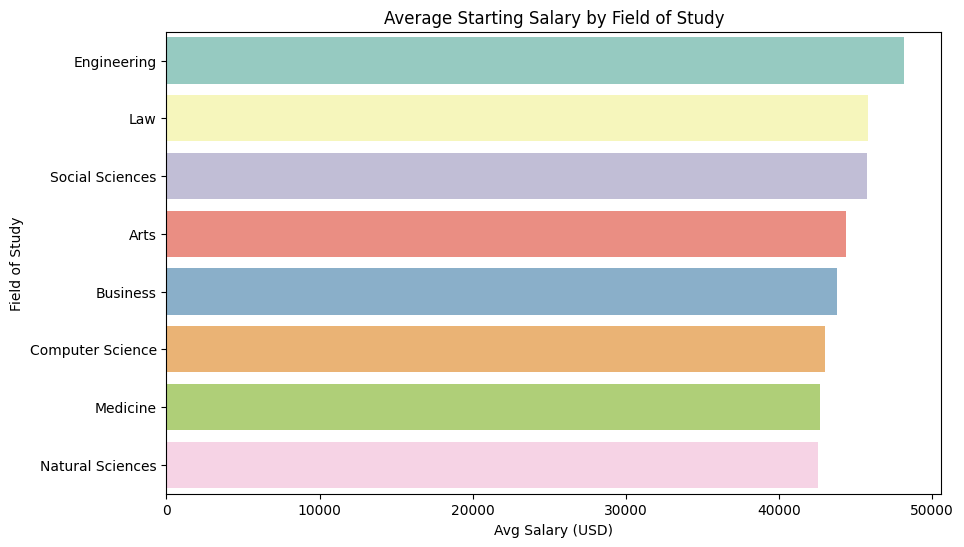

In [44]:
#Average Starting Salary by Field

salary_field = df.groupby('field_of_study')['starting_salary_usd'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=salary_field.values, y=salary_field.index, palette='Set3')
plt.title('Average Starting Salary by Field of Study')
plt.xlabel('Avg Salary (USD)')
plt.ylabel('Field of Study')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



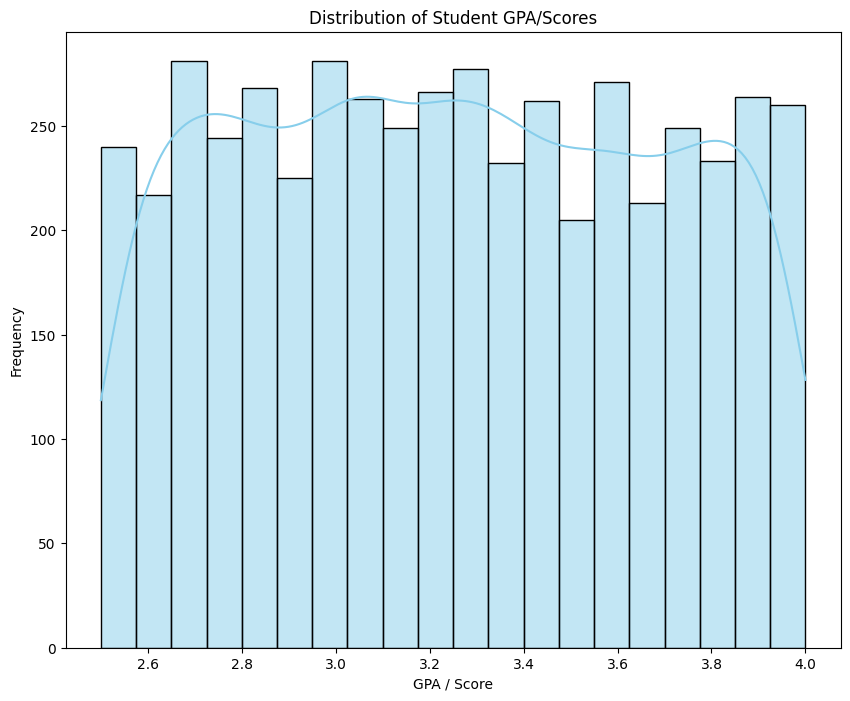

In [45]:
#GPA Distribution Histogram

plt.figure(figsize=(10,8))
sns.histplot(df['gpa_or_score'],bins=20, kde=True, color='skyblue')
plt.title('Distribution of Student GPA/Scores')
plt.xlabel('GPA / Score')
plt.ylabel('Frequency')
plt.show()

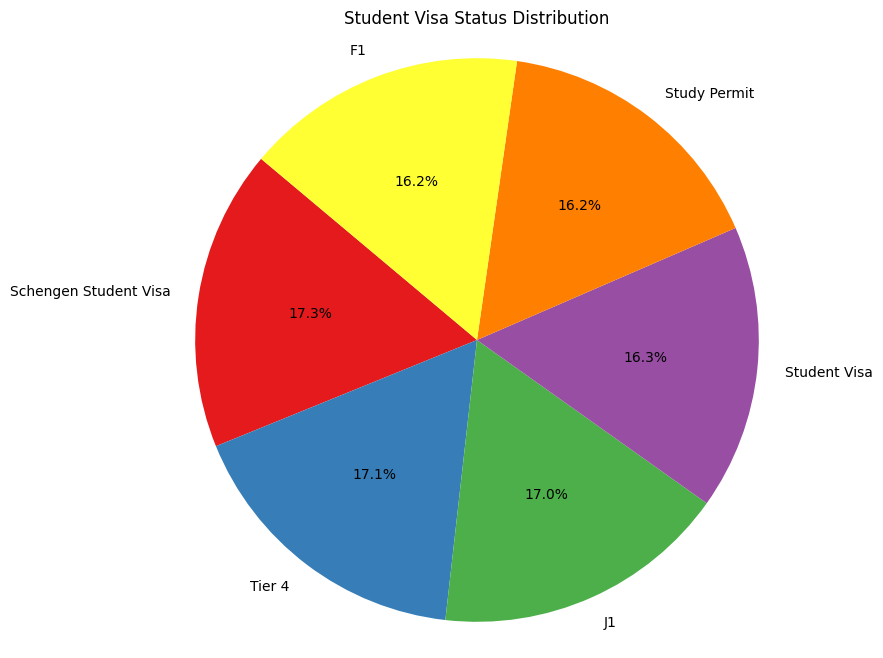

In [47]:
#Visa Status Pie Chart

visa_counts = df['visa_status'].value_counts()
plt.figure(figsize=(8,8))
plt.pie(visa_counts.values, labels=visa_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set1'))
plt.title('Student Visa Status Distribution')
plt.axis('equal')
plt.show()

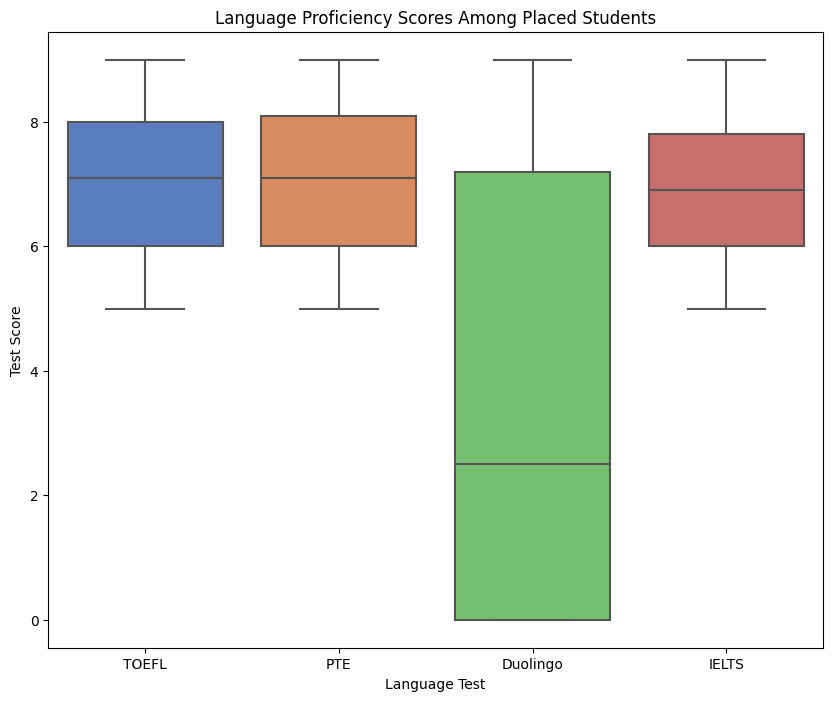

In [51]:
#Language Proficiency Test Score vs Placement

plt.figure(figsize=(10, 8))
sns.boxplot(data=df[df['placement_status'] == 'Placed'], x='language_proficiency_test', y='test_score', palette='muted')
plt.title('Language Proficiency Scores Among Placed Students')
plt.xlabel('Language Test')
plt.ylabel('Test Score')
plt.show()

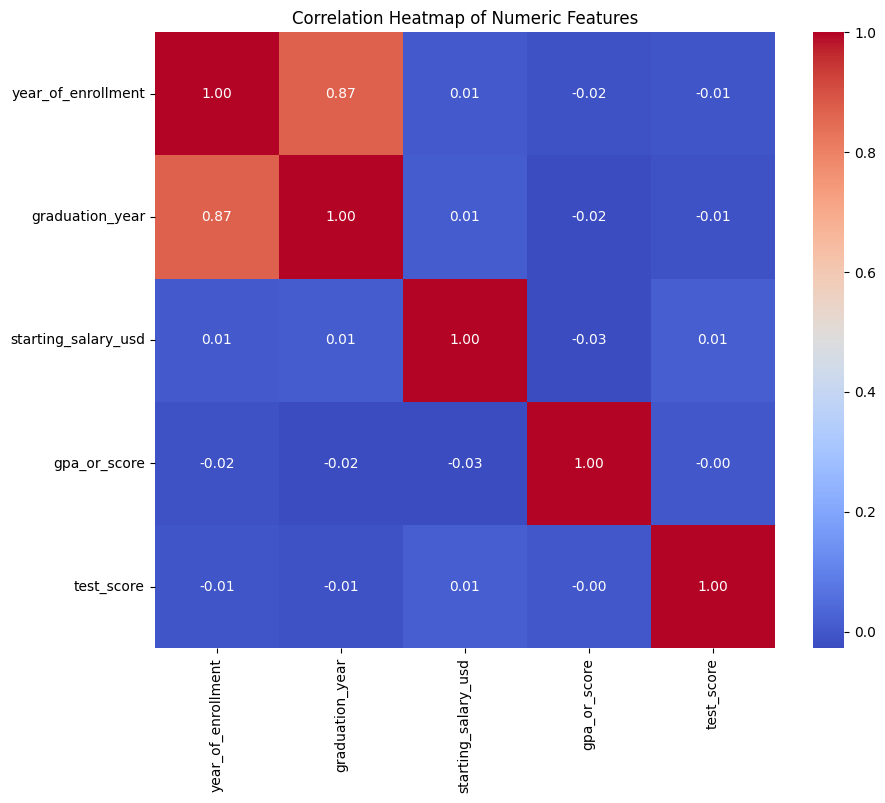

In [52]:
# Using multiple numeric columns for correlation heatmap if available
numeric_df = df.select_dtypes(include=[np.number])
if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(10, 8))
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.show()

# Predictive modeling

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [54]:
# Drop columns with too much variability or leakage (e.g., student_id, placement_company)

drop_cols =['student_id','placement_company','starting_salary_usd']
df.drop(columns=drop_cols, inplace=True)

# Handle missing values (simple fill or drop)
df.fillna(method='ffill', inplace=True)

# Encode target variable
df['placement_status'] = df['placement_status'].map({'Placed': 1, 'Not Placed': 0})

# Label encode categorical columns
label_cols = df.select_dtypes(include='object').columns
le = LabelEncoder()
for col in label_cols:
    df[col] = le.fit_transform(df[col])

# Features and Target
X = df.drop('placement_status', axis=1)
y = df['placement_status']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/tmp/ipykernel_36/1880793073.py:7: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [56]:
#Define models

models = {
    'Logistic Regression': LogisticRegression(max_iter=1500),
    'Random Forest Classifier': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machine': SVC()
}

#Train and evaluate
accuracy_results={}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred) * 100
    accuracy_results[name] = round(acc, 2)

# Display accuracies
print("Model Accuracies:")
for model, acc in accuracy_results.items():
    print(f"{model}: {acc}%")

Model Accuracies:
Logistic Regression: 86.1%
Random Forest Classifier: 96.1%
Gradient Boosting: 96.5%
Decision Tree: 96.5%
K-Nearest Neighbors: 77.9%
Support Vector Machine: 47.5%


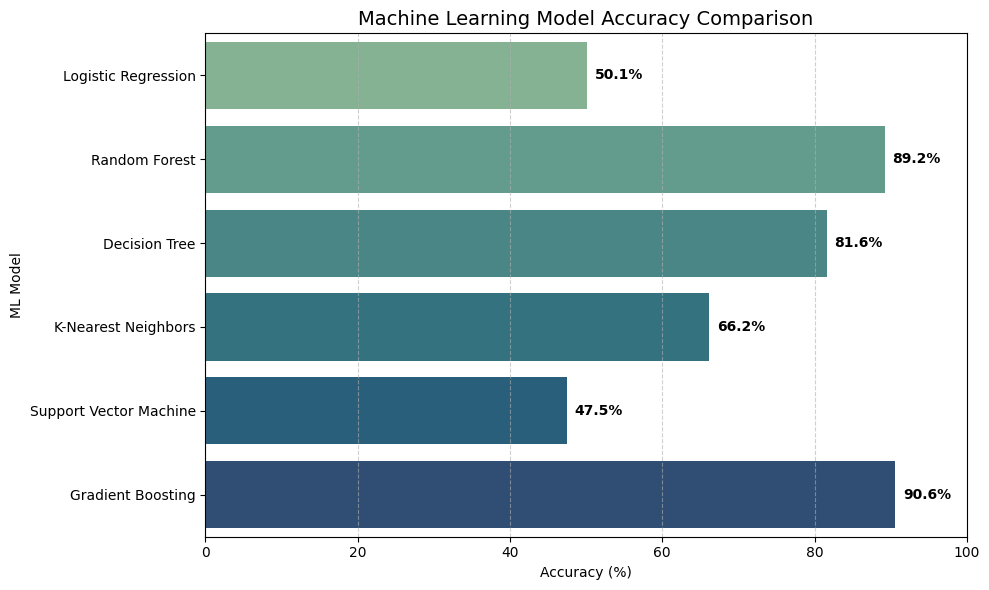

In [59]:
# Accuracy results (from output)

accuracy_results={
    'Logistic Regression': 50.1,
    'Random Forest': 89.2,
    'Decision Tree': 81.6,
    'K-Nearest Neighbors': 66.2,
    'Support Vector Machine': 47.5,
    'Gradient Boosting': 90.6
}

# Convert to DataFrame for easy plotting
import pandas as pd
acc_df = pd.DataFrame(list(accuracy_results.items()), columns=['Model', 'Accuracy'])

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=acc_df, x='Accuracy', y='Model', palette='crest', orient='h')

# Add accuracy values to bars
for index, value in enumerate(acc_df['Accuracy']):
    plt.text(value + 1, index, f"{value}%", va='center', fontweight='bold')

plt.title('Machine Learning Model Accuracy Comparison', fontsize=14)
plt.xlabel('Accuracy (%)')
plt.ylabel('ML Model')
plt.xlim(0, 100)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()